In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import seaborn as sn
import pandas as pd
from tqdm import tqdm

In [2]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

##Getting training set
train_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

##Getting test set
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
latent_vector = 16
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=64)
        self.enc3 = nn.Linear(in_features=64, out_features=8)
        self.enc4 = nn.Linear(in_features=8, out_features=latent_vector*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=latent_vector, out_features=8)
        self.dec2 = nn.Linear(in_features=8, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=256)
        self.dec4 = nn.Linear(in_features=256, out_features=784)
        
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x, encode = True):
        if encode:
            x = torch.relu(self.enc1(x))
            x = torch.relu(self.enc2(x))
            x = torch.relu(self.enc3(x))
            x = self.enc4(x).view(-1, 2, latent_vector)
        
            # get `mu` and `log_var`    ( 2, latent_vector_dimension)
            mu = x[:, 0, :] # the first feature values as mean
            log_var = x[:, 1, :] # the other feature values as variance
            
            
        else:
            #if only decoding needs to be done, then x is given as a list [mu, logvar]
            mu = x[0]
            log_var = x[1]
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = torch.relu(self.dec1(z))
        x = torch.relu(self.dec2(x))
        x = torch.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')#nn.MSELoss()

In [6]:
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [7]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(dataloader):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [8]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [9]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, test_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20
Train Loss: 253.2558
Val Loss: 198.6751
Epoch 2 of 20
Train Loss: 196.4108
Val Loss: 194.8410
Epoch 3 of 20
Train Loss: 193.2344
Val Loss: 189.2688
Epoch 4 of 20
Train Loss: 186.1151
Val Loss: 182.5605
Epoch 5 of 20
Train Loss: 179.9023
Val Loss: 174.6697
Epoch 6 of 20
Train Loss: 168.6669
Val Loss: 162.0025
Epoch 7 of 20
Train Loss: 158.0418
Val Loss: 154.0803
Epoch 8 of 20
Train Loss: 151.4941
Val Loss: 149.1453
Epoch 9 of 20
Train Loss: 147.2390
Val Loss: 145.0589
Epoch 10 of 20
Train Loss: 143.8135
Val Loss: 143.3456
Epoch 11 of 20
Train Loss: 140.9378
Val Loss: 140.2734
Epoch 12 of 20
Train Loss: 138.6356
Val Loss: 137.2729
Epoch 13 of 20
Train Loss: 136.8202
Val Loss: 135.5932
Epoch 14 of 20
Train Loss: 135.3205
Val Loss: 134.4783
Epoch 15 of 20
Train Loss: 134.1616
Val Loss: 134.5236
Epoch 16 of 20
Train Loss: 133.1124
Val Loss: 132.5129
Epoch 17 of 20
Train Loss: 132.0969
Val Loss: 131.8114
Epoch 18 of 20
Train Loss: 131.3417
Val Loss: 131.0350
Epoch 19 of 20
Trai

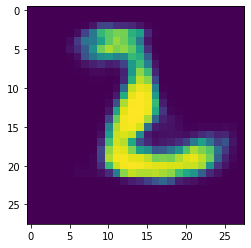

In [13]:
mu = torch.tensor(np.array([1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0])).float()
#logvar = torch.tensor(np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0])).float()
#mu = torch.tensor(np.zeros((1, latent_vector))).float()
logvar = torch.tensor(np.zeros((1, latent_vector))).float()
representation = [mu, logvar]
with torch.no_grad():
    reconstruction,_, _ = model.forward(representation, encode=False)
    plt.imshow(reconstruction.numpy().reshape(28, 28))